In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from pmdarima import ARIMA
from pmdarima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

The data is in an xlsx file

The file contains information on drought levels, organized by city and state, reported since January 2003 and recorded biweekly

In [2]:
file_name = "sequia2023.xlsx"
sheet_name = 0
df = pd.read_excel(file_name, sheet_name=sheet_name)

In [3]:
df.head()

,CVE_CONCATENADA,CVE_ENT,CVE_MUN,NOMBRE_MUN,ENTIDAD,ORG_CUENCA,CLV_OC,CON_CUENCA,CVE_CONC,2003-01-31 00:00:00,...,2023-08-15 00:00:00,2023-08-31 00:00:00,2023-09-15 00:00:00,2023-09-30 00:00:00,2023-10-15 00:00:00,2023-10-31 00:00:00,2023-11-15 00:00:00,2023-11-30 00:00:00,2023-12-15 00:00:00,2023-12-31 00:00:00
0,1001,1,1,Aguascalientes,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D1,D1
1,1002,1,2,Asientos,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D2,D1,D1
2,1003,1,3,Calvillo,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D3,D3
3,1004,1,4,Cosío,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D2,D2,D3,D3,D3,D3,D3,D3,D2,D2
4,1005,1,5,Jesús María,Aguascalientes,Lerma Santiago Pacífico,VIII,Rio Santiago,16,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D2,D2


#### Data preparation 

We will remove the unnecessary columns, as the majority of them are identification keys.

We will also remove the cities from each state, as our focus will be uniquely on states. We only need to know the state and the historical data of the droughts.

In [4]:
df = df.drop(columns=["CVE_CONCATENADA","CVE_ENT","CVE_MUN","NOMBRE_MUN", "ORG_CUENCA", "CLV_OC","CVE_CONC","CON_CUENCA","CVE_CONC"])

In [5]:
df.head()

,ENTIDAD,2003-01-31 00:00:00,2003-02-28 00:00:00,2003-03-31 00:00:00,2003-04-30 00:00:00,2003-05-31 00:00:00,2003-06-30 00:00:00,2003-07-31 00:00:00,2003-08-31 00:00:00,2003-09-30 00:00:00,...,2023-08-15 00:00:00,2023-08-31 00:00:00,2023-09-15 00:00:00,2023-09-30 00:00:00,2023-10-15 00:00:00,2023-10-31 00:00:00,2023-11-15 00:00:00,2023-11-30 00:00:00,2023-12-15 00:00:00,2023-12-31 00:00:00
0,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D1,D1
1,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D2,D1,D1
2,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D3,D3
3,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D2,D2,D3,D3,D3,D3,D3,D3,D2,D2
4,Aguascalientes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D3,D3,D3,D3,D3,D3,D3,D3,D2,D2


#### Replacing the drought levels with numerical values as follows:

1. Minimum (10% water reduction) D0 = 1

2. Moderate (15%) D1= 2
   
3. Moderate (25%) D2= 3

4. Severe (40%) D3= 4

5. Critical (>40%) D4= 5

In [6]:
df_replace = df.replace({'D0': 1,'D1':2,'D2':3,'D3':4,'D4':5})

#### Missing values:
All NA values do not indicate missing data; rather, they signify that no drought was reported on those days. Therefore, we will replace them with 0.

In [7]:
df_replace=df_replace.fillna(0)

In [8]:
df_replace.head()

,ENTIDAD,2003-01-31 00:00:00,2003-02-28 00:00:00,2003-03-31 00:00:00,2003-04-30 00:00:00,2003-05-31 00:00:00,2003-06-30 00:00:00,2003-07-31 00:00:00,2003-08-31 00:00:00,2003-09-30 00:00:00,...,2023-08-15 00:00:00,2023-08-31 00:00:00,2023-09-15 00:00:00,2023-09-30 00:00:00,2023-10-15 00:00:00,2023-10-31 00:00:00,2023-11-15 00:00:00,2023-11-30 00:00:00,2023-12-15 00:00:00,2023-12-31 00:00:00
0,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0
1,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0
2,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0
4,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0


The 'Entidad' column contains the states of the country, repeated because the database is divided into cities. However, our objective is to determine the drought level by state. Therefore, the maximum value will be taken, meaning the highest drought level among all the cities belonging to a specific state will be assigned to the state. This approach is preferred because if there is a possibility that one city within the state has a high drought level, it is more prudent to consider the most critical situation rather than the average, for example.

In [9]:
df_replace["ENTIDAD"].unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila de Zaragoza', 'Colima', 'Chiapas',
       'Chihuahua', 'Ciudad de México', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'Estado de México',
       'Michoacán de Ocampo', 'Morelos', 'Nayarit', 'Nuevo León',
       'Oaxaca', 'Puebla', 'Querétaro de Arteaga', 'Quintana Roo',
       'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas',
       'Tlaxcala', 'Veracruz de Ignacio de la Llave', 'Yucatán',
       'Zacatecas'], dtype=object)

In [10]:
new_df = df_replace.groupby('ENTIDAD').max()
new_df.head()

,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,...,2023-08-15,2023-08-31,2023-09-15,2023-09-30,2023-10-15,2023-10-31,2023-11-15,2023-11-30,2023-12-15,2023-12-31
ENTIDAD,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
Baja California,4.0,3.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Baja California Sur,3.0,3.0,3.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Campeche,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
Chiapas,2.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,1.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


We will create a new dataframe containing the maximum values and transpose it, so that each state is represented in a separate column.

In [12]:
df_trans = new_df.T 
df_trans.head()

ENTIDAD,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila de Zaragoza,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
2003-01-31 00:00:00,0.0,4.0,3.0,1.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,0.0,0.0
2003-02-28 00:00:00,0.0,3.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,1.0,0.0
2003-03-31 00:00:00,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,0.0
2003-04-30 00:00:00,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0
2003-05-31 00:00:00,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0


In [13]:
df_trans.index = pd.to_datetime(df_trans.index)

In [15]:
df_trans.head()

ENTIDAD,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila de Zaragoza,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
2003-01-31,0.0,4.0,3.0,1.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,0.0,0.0
2003-02-28,0.0,3.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,2.0,1.0,2.0,1.0,0.0
2003-03-31,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,0.0
2003-04-30,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0
2003-05-31,0.0,2.0,3.0,2.0,2.0,4.0,1.0,3.0,0.0,3.0,...,0.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0


In [17]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 370 entries, 2003-01-31 to 2023-12-31
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Aguascalientes                   370 non-null    float64
 1   Baja California                  370 non-null    float64
 2   Baja California Sur              370 non-null    float64
 3   Campeche                         370 non-null    float64
 4   Chiapas                          370 non-null    float64
 5   Chihuahua                        370 non-null    float64
 6   Ciudad de México                 370 non-null    float64
 7   Coahuila de Zaragoza             370 non-null    float64
 8   Colima                           370 non-null    float64
 9   Durango                          370 non-null    float64
 10  Estado de México                 370 non-null    float64
 11  Guanajuato                       370 non-null    float64
 12  Gue

In [48]:
df_trans = df_trans.astype(int)

In [49]:
df_trans.describe()

ENTIDAD,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila de Zaragoza,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,...,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,0.854054,2.321622,1.159459,1.332432,1.829730,2.548649,0.802703,2.437838,0.981081,2.045946,...,1.167568,1.945946,2.000000,2.835135,1.389189,2.383784,0.810811,2.121622,1.297297,1.597297
std,1.223216,1.380003,1.191196,1.074603,1.249686,1.359125,0.840372,1.555714,1.047474,1.355726,...,0.987196,1.254714,1.333333,1.188179,1.287796,1.428990,0.853427,1.147080,1.078614,1.320053
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.250000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,3.000000,1.000000,2.000000,...,1.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
75%,2.000000,4.000000,2.000000,2.000000,3.000000,3.000000,1.000000,4.000000,2.000000,3.000000,...,2.000000,3.000000,3.000000,4.000000,2.000000,4.000000,1.000000,3.000000,2.000000,3.000000
max,5.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,...,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000


We observe that nearly all states exhibit maximum values of 5, which is the highest level of drought.

In [51]:
high= df_trans.describe().loc['mean'] >= 2
results = df_trans.describe().loc[:, high]
print(results)

ENTIDAD  Baja California   Chihuahua  Coahuila de Zaragoza     Durango  \
count         370.000000  370.000000            370.000000  370.000000   
mean            2.321622    2.548649              2.437838    2.045946   
std             1.380003    1.359125              1.555714    1.355726   
min             0.000000    0.000000              0.000000    0.000000   
25%             1.000000    1.250000              1.000000    1.000000   
50%             2.000000    2.000000              3.000000    2.000000   
75%             4.000000    3.000000              4.000000    3.000000   
max             5.000000    5.000000              5.000000    5.000000   

ENTIDAD     Jalisco  Michoacán de Ocampo      Oaxaca     Sinaloa      Sonora  \
count    370.000000           370.000000  370.000000  370.000000  370.000000   
mean       2.016216             2.094595    2.227027    2.000000    2.835135   
std        1.161607             1.163689    1.224114    1.333333    1.188179   
min        0.

In [52]:
df_trans.mean().mean()

1.7191722972972974

The country's average is 1.79, which means that the country suffers from many droughts, a good average would be a value close to 0.

For this project we will randomly select 3 states, one from each region of Mexico: Colima, Morelos, Quintana Roo and Sonora to apply the model

In [19]:
df_new2  = df_trans.loc[:, ['Colima', 'Morelos','Quintana Roo','Sonora']]
df_new2.head()

ENTIDAD,Colima,Morelos,Quintana Roo,Sonora
2003-01-31,0,3,0,5
2003-02-28,0,3,0,5
2003-03-31,0,3,0,5
2003-04-30,0,3,0,5
2003-05-31,0,3,0,5


Once our data is prepared, we will plot the drought levels for all states to observe their behavior since 2003.

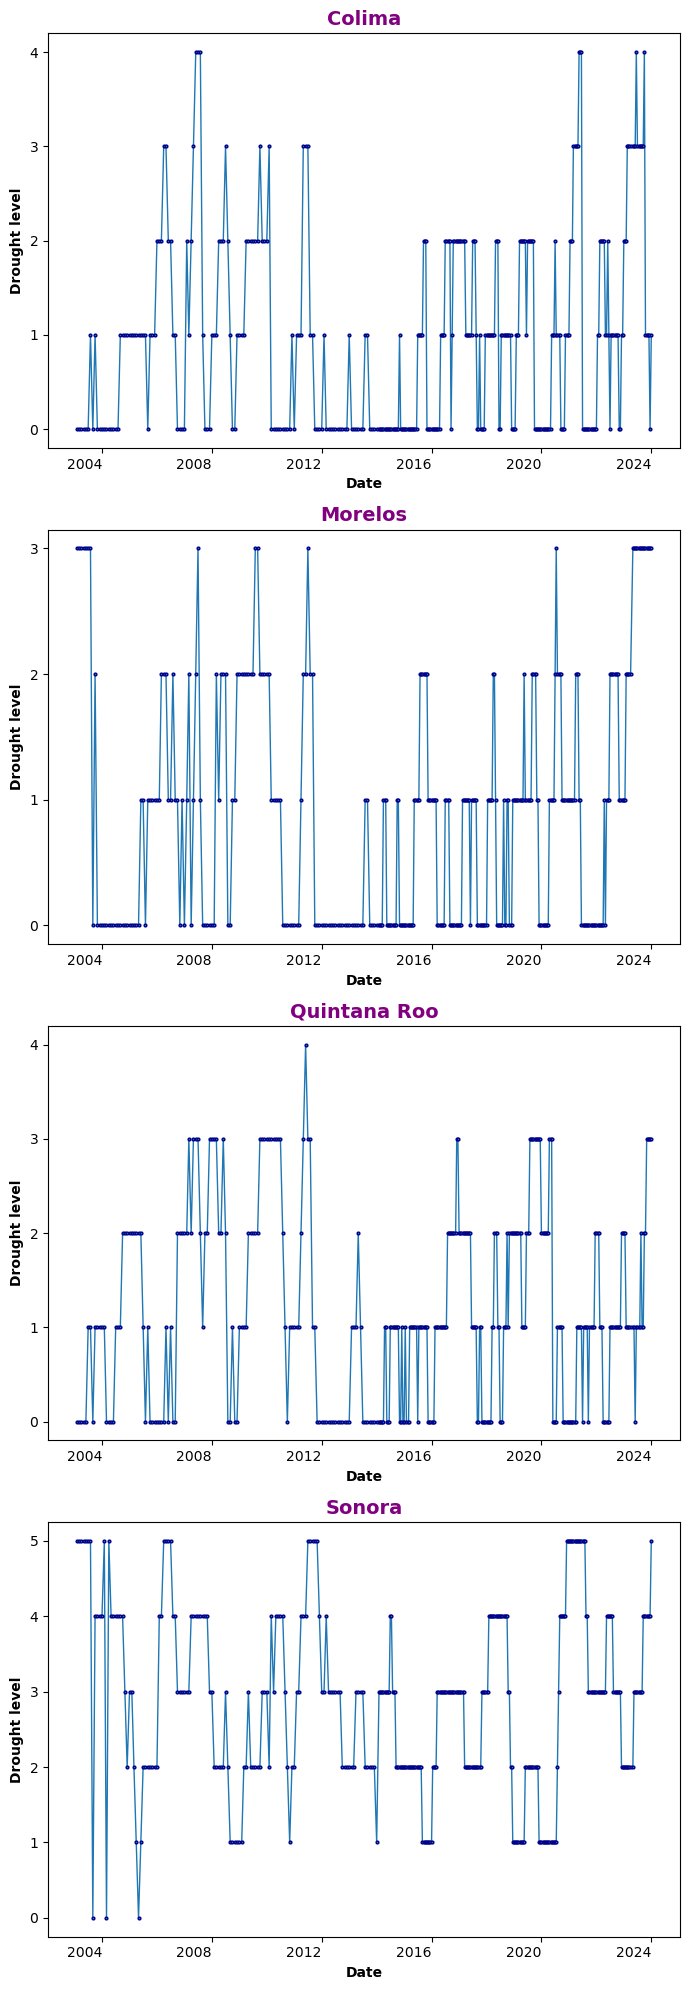

In [42]:
fig, axes = plt.subplots(nrows=len(df_new2.columns), ncols=1, figsize=(7, 5*len(df_new2.columns)))
#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
#axes = axes.flatten()

for i, col in enumerate(df_new2.columns):
    df_new2[col].plot(ax=axes[i],marker='o',markersize=2,markeredgecolor='darkblue',linewidth=1)
    axes[i].set_ylabel('Drought level',fontweight='bold')  
    axes[i].set_xlabel('Date',fontweight='bold')
    axes[i].set_title(col,fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'purple'})
    axes[i].xaxis.set_tick_params(rotation=0)  
    y_ticks = range(int(df_new2[col].min()), int(df_new2[col].max()) + 1) 
    axes[i].set_yticks(y_ticks)
    
plt.tight_layout()

plt.show()

To observe the recent trends over the past 2 years, we will graph the last 49 records

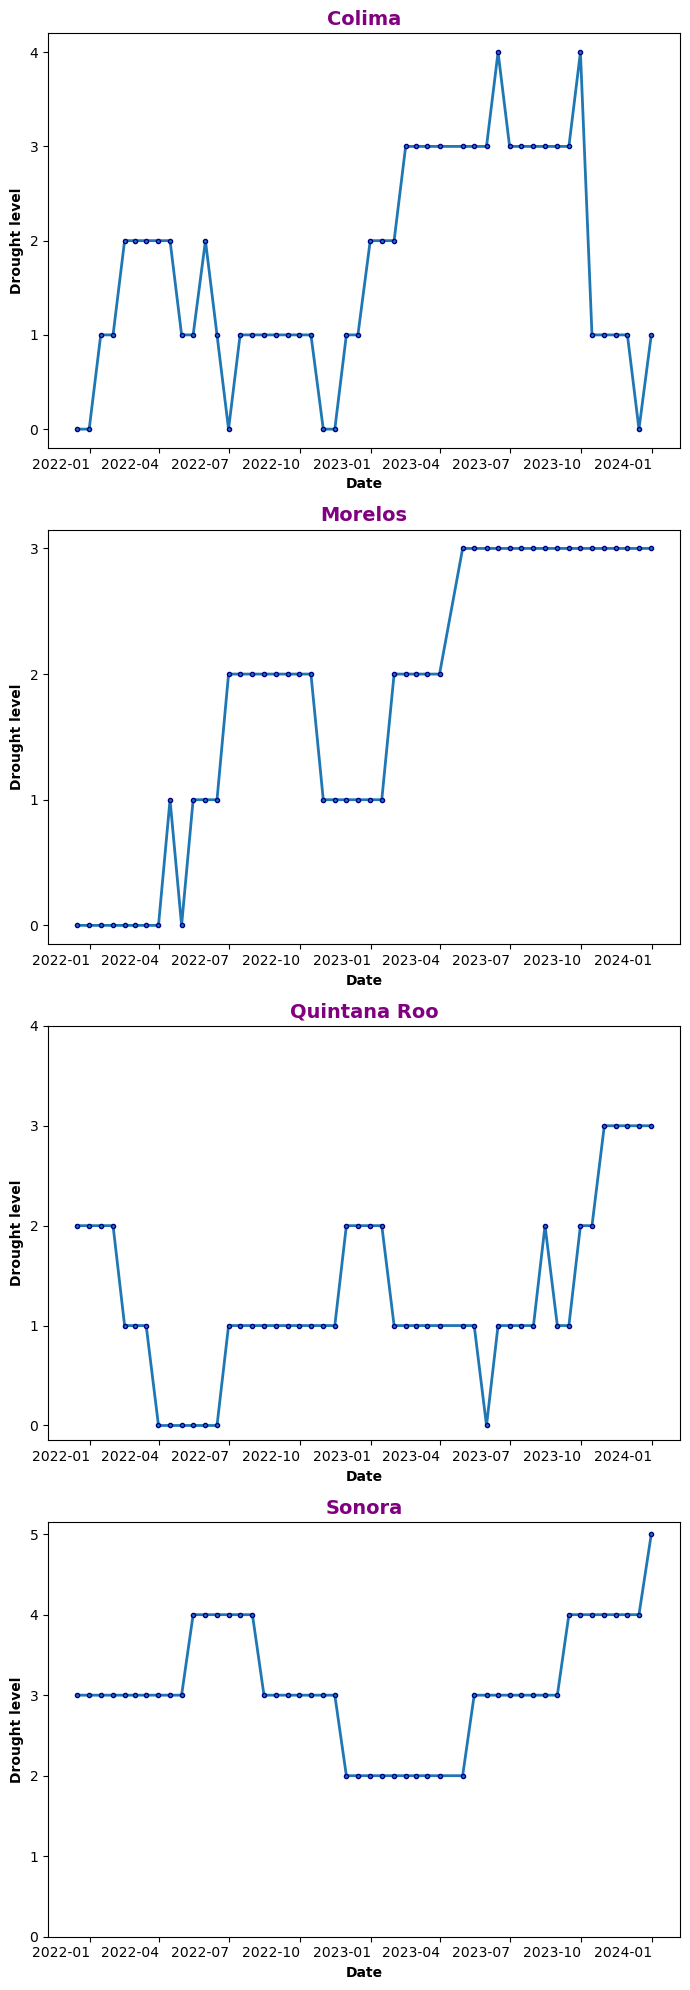

In [46]:
ultimas_20_filas = df_new2.tail(49)

fig, axes = plt.subplots(nrows=len(df_new2.columns), ncols=1, figsize=(7, 5*len(df_new2.columns)))


for i, col in enumerate(df_new2.columns):
    ultimas_20_filas[col].plot(ax=axes[i],marker='o',markersize=3,markeredgecolor='darkblue',linewidth=2)
    axes[i].set_ylabel('Drought level',fontweight='bold')  
    axes[i].set_xlabel('Date',fontweight='bold')
    axes[i].set_title(col,fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'purple'}) 
    axes[i].xaxis.set_tick_params(rotation=0)  
    y_ticks = range(int(df_new2[col].min()), int(df_new2[col].max()) + 1) 
    axes[i].set_yticks(y_ticks)

plt.tight_layout()

plt.show()

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.ticker as plticker

In [53]:
orig_df = df_new2.copy()